# HomeWork Assignment 4: Fine Tuning IMDB Using BERT, XLNet, RoBERTa, and DistilBERT


Department of Statistics, Kyeongwon Lee

* 발표자료는 [github repository](https://github.com/kw-lee/2019compling1/blob/master/hw/hw4/Presentation.ipynb)에서 확인하실 수 있습니다.

## Settings

* environment: [google colab](https://drive.google.com/file/d/1tS1zuhf4OyY_IPMKb8o3UmqOEfURz7Pb/view?usp=sharing) (figure가 포함된 notebook)
```python
random.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)
```

* Data
    * 전체 자료를 사용할 경우, training 과정에서 12배의 시간이 필요 (약 24시간 예상)
    * 컴퓨터의 성능 문제로 일부 데이터만 사용하기로 결정
    
* Learning Schedule
```python
BATCH_SIZE = 4
EPOCHS = 10
lr = 3e-6
train_n = len(train_y)
train_bat = train_n / BATCH_SIZE
```

* Model Architecture: `token` -> `Pretrained-Model` -> `ReLU` -> `FC with dropout` -> `sigmoid` -> `label` 의 형태로 통일

* Optimizer
```python
optimizer = Adam(bert_clf.parameters(), lr = lr)
```

* Fine tune
    * multi-gpu로 학습을 시도하였으나, 학습시간에 큰 차이를 보이지 않아 (약 20%) 1개의 gpu로만 학습을 진행
    * 다음과 같이 추가한 layer만 학습을 시도하였으나, 성능이 매우 좋지 않아 (accuracy = 0.5) BASE 모형도 함께 fine-tuning 하는 것으로 결정 
    ```python
    for name, params in bert_clf.named_parameters():
        if 'bert' in name:
            params.requires_grad=False
    ```

## Load Libraries

In [0]:
#  !pip install transformers sklearn

In [0]:
import sys
import numpy as np
import random
import torch
import csv
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import transformers
from torch import nn
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
from transformers import BertTokenizer, BertModel
from sklearn.metrics import classification_report

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

Using TensorFlow backend.


In [0]:
random.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

## Prepare the Data

* 전체 자료를 사용할 경우, training 과정에서 12배의 시간이 필요 (약 24시간 예상)
* 컴퓨터의 성능 문제로 일부 데이터만 사용하기로 결정

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# load dataset
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/imdb_master.csv', encoding='latin-1')

# preprocessing
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.drop(['file'], axis = 1, inplace = True)
df = df[df['label'] != 'unsup'] # only for neg or pos

# use a part of the dataset 
train_df = df[df['type'] == 'train'][:1000].append(df[df['type'] == 'train'][-1000:])
test_df = df[df['type'] =='test'][:100].append(df[df['type'] =='test'][-100:])

# train_df = df[df['type'] == 'train']
# test_df = df[df['type'] == 'test']

# - 'review', 'label'을 각각 추출
train_texts = train_df['review'].tolist()
test_texts = test_df['review'].tolist()
train_labels = train_df['label']
test_labels = test_df['label']

# convert label to number
train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'

In [0]:
print(len(train_texts), len(test_texts))
print(len(train_labels), len(test_labels))

2000 200
2000 200


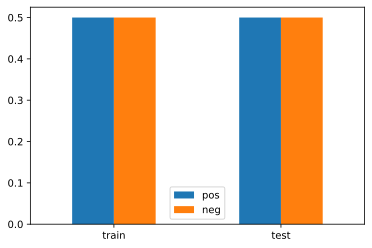

In [0]:
# visualize proportion
pos = [np.mean(train_y), np.mean(test_y)]
neg = [1-np.mean(train_y), 1-np.mean(test_y)]
prop = pd.DataFrame( {'pos': pos, 'neg': neg}, 
                   index = ['train', 'test'])
ax = prop.plot.bar(rot = 0)

## Learning schedule

In [0]:
BATCH_SIZE = 4
EPOCHS = 10
lr = 3e-6
train_n = len(train_y)
train_bat = train_n / BATCH_SIZE

## Tokenizing Data

- BertTokenizer를 쓰는 경우
- XLNET, RoBERTa, DistilBERT에서는 각각 자기 모델에 맞는 tokenizer를 불러와야 함
- 최대 입력문장 길이를 512로 하기 때문에 여기에 맞춰 train_texts의 자료에 각 `[CLS]`, `[SEP]`를 앞뒤에 붙여서 train_tokens와 test_tokens를 완성
- 이때, 모형에 따라 `[CLS]`, `[SEP]`가 달라 `tokenizer.*_token` 사용

In [0]:
def tokenizing_data(tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)):
    """
    input: tokenizer
    output: dataloaders (train/test)
    """
    train_tokens = list(map(lambda t: [tokenizer.cls_token] + tokenizer.tokenize(t)[:510] + [tokenizer.sep_token], train_texts))
    test_tokens = list(map(lambda t: [tokenizer.cls_token] + tokenizer.tokenize(t)[:510] + [tokenizer.cls_token], test_texts))
    
    # train/test_tokens_ids
    train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
    test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
    
    #masking
    train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
    test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]
    
    train_tokens_tensor = torch.tensor(train_tokens_ids)
    train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

    test_tokens_tensor = torch.tensor(test_tokens_ids)
    test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

    train_masks_tensor = torch.tensor(train_masks)
    test_masks_tensor = torch.tensor(test_masks)

    train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

    test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)
    
    return (train_dataloader, test_dataloader)

## BERT

In [0]:
random.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

### Tokenizing

In [0]:
train_dataloader, test_dataloader = \
    tokenizing_data(tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True))

### Declare Model

In [0]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.2):
        """
        token -> bert -> relu -> FC with dropout -> sigmoid -> label
        """
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks)
        output = self.dropout(pooled_output)
        output = self.relu(output)
        output = self.linear(output)
        output = self.sigmoid(output)
        return output

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
bert_clf = BertBinaryClassifier()

device: cuda


### Optimizer

다음과 같이 BERT 이후의 layer만 학습을 시도하였으나, 성능이 매우 좋지 않아 (accuracy = 0.5) BERT 모형도 함께 fine-tuning하였다.
```python
for name, params in bert_clf.named_parameters():
    if 'bert' in name:
        params.requires_grad=False
```

In [0]:
# Adam
optimizer = Adam(bert_clf.parameters(), lr = lr)

### Fine-tune

multi-gpu로 학습을 시도하였으나, 학습시간에 큰 차이를 보이지 않아 (약 20%) 1개의 gpu로만 학습을 진행하였다.

In [0]:
# if 'bert_clf.pkl' in os.listdir('./models'):
if False:
    # load the model
    bert_clf = BertBinaryClassifier()
    bert_clf.load_state_dict(torch.load('./models/bert_clf.pkl'))
    bert_loss = pd.read_csv('./models/bert_loss.csv', header=None).values.tolist()
    bert_clf = bert_clf.to(device)
else:
    # train the model
    bert_clf = bert_clf.to(device)
#     bert_clf = nn.DataParallel(bert_clf)
    tic = time.time()
    bert_loss = []
    for epoch_num in range(EPOCHS):
        bert_clf.train()
        train_loss = 0
        for step_num, batch_data in enumerate(train_dataloader):
            token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
            
            logits = bert_clf(token_ids, masks)

            loss_func = nn.BCELoss()

            batch_loss = loss_func(logits, labels)
            train_loss += batch_loss.item()

            bert_clf.zero_grad()
            batch_loss.backward()

            clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
            optimizer.step()
            
            step_num += 1
            if not (step_num % 10):
                steps = step_num + epoch_num * train_bat
                job_prop = steps / (EPOCHS * train_bat)
                clear_output(wait=True)
                elapsed = time.time() - tic
                print('Epoch: {0}, Elapsed: {1}'.format(epoch_num + 1, elapsed))
                bert_loss.append(train_loss / (step_num + 1))
                print("\r" + "{0}/{1} loss: {2} ".format(step_num, train_bat, train_loss / (step_num + 1)))
                print("\r" + "{:2.2f}% done".format(100 * job_prop))
            
    # # save the model
    # torch.save(bert_clf.state_dict(), './models/bert_clf.pkl')
    
    # # save the loss
    # with open('./models/bert_loss.csv', 'w') as myfile:
    #     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    #     wr.writerow(bert_loss)

Epoch: 10, Elapsed: 1365.5636875629425
500/500.0 loss: 0.04276571744409745 
100.00% done


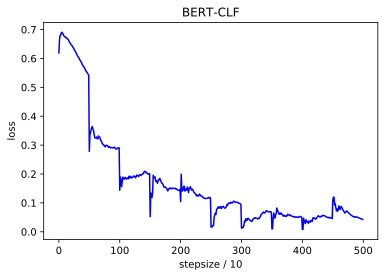

In [0]:
plt.plot(bert_loss, 'b')
plt.ylabel('loss')
plt.xlabel('stepsize / 10')
plt.title('BERT-CLF')
plt.show()

### Test

In [0]:
bert_clf.eval()
bert_predicted = []
all_logits = []

with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [0]:
## accuracy
bert_accuracy = np.mean(test_y == bert_predicted)
bert_accuracy

0.89

### BV-BERT

Gal, Y. (2016).의 논문을 참고하여 예측을 eval mode (multiplying dropout prob.)가 아닌 train mode에서 실시하였다. 이때, 평균값을 output으로 표준편차를 uncertainty의 측도로 사용하였다. 

In [0]:
bert_clf.train()
n_sample = 20
logits_sample = np.zeros([n_sample, len(test_y)])
with torch.no_grad():
    for i in range(n_sample):
        all_logits = []
        for step_num, batch_data in enumerate(test_dataloader):

            token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

            logits = bert_clf(token_ids, masks)
            numpy_logits = logits.cpu().detach().numpy()
            all_logits += list(numpy_logits[:, 0])
        logits_sample[i,:] = all_logits

In [0]:
test_pred = np.mean(logits_sample, axis = 0)
test_std = np.std(logits_sample, axis = 0)

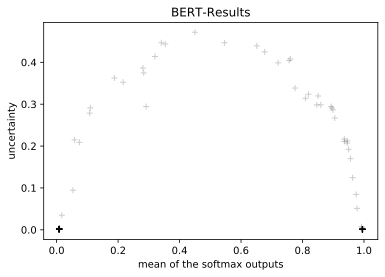

In [0]:
# Gal, Y. (2016). Uncertainty in Deep Learning. PhD Thesis, University of Cambridge, (September). https://doi.org/10.1371/journal.pcbi.1005062
# figure 4.9
plt.plot(test_pred, test_std, 'k+', alpha = 0.2)
plt.xlabel('mean of the softmax outputs')
plt.ylabel('uncertainty')
plt.title('BERT-Results')
plt.show()

In [0]:
# sure
print("label: {0}, predicted: {1},\n text: {2}".format(test_labels.tolist()[np.argmin(test_std)], \
                                                       test_pred[np.argmin(test_std)], test_texts[np.argmin(test_std)]))

label: pos, predicted: 0.9954129070043564,
 text: Often considered Argento's last "great" film, this entry into the giallo canon is unquestionably better than any Argento film that has followed it (though I have yet to see "Mother of Tears"), but to call it his last "great" film might be stretching it a bit.<br /><br />The directorial and stylistic flourishes - the hallmark of all Argento films - is indeed present, with some of his sequences of suspense ranking up with his best (the "peephole" sequence is especially memorable), and the cinematography by Ronnie Taylor is outstanding (the fluorescent lighting is beautiful).<br /><br />However, the narrative - which is hit and miss in all of Argento's films - is missing here. There is indeed a potent sense of mystery and intrigue, but the plot resorts to what is essentially a string of murder sequences, with one following the another, leaving no real time to fully construct a right, focused mystery to be solved. All of this results in a c

In [0]:
# unsure
print("label: {0}, predicted: {1},\n text: {2}".format(test_labels.tolist()[np.argmax(test_std)], \
                                                       test_pred[np.argmax(test_std)], test_texts[np.argmax(test_std)]))

label: neg, predicted: 0.4499258782947436,
 text: CAUTION SPOILER: At the end of the movie it is announced that the bridge collapsed just a few days after it was captured. The impression is that the attack was all for nothing. In reality, taking the bridge at Remagen was the last important victory for the Western Allies. It was the crossing of the Rhine that the Allies had been trying to achieve for six months. Because the Remagen Bridge was taken, the war ended in just a few weeks.<br /><br />The bridge only need to last for a day after it was captured. This was enough time for the Americans to send combat engineers and a large protective force to the other side, and they could then start building a series of pontoon bridges. The taking of the bridge was a complete success, and meant the that the end of the war was near, and would not last through the summer. Contrary to the cynical nature of the film, the victory was heralded with elation by the troops who did it. They knew how vital

In [0]:
del bert_clf
torch.cuda.empty_cache()

##  XLNet

In [0]:
random.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

### Tokenizing

In [0]:
# refer https://github.com/huggingface/transformers
train_dataloader, test_dataloader = \
    tokenizing_data(tokenizer = transformers.XLNetTokenizer.from_pretrained('xlnet-base-cased'))

100%|██████████| 798011/798011 [00:00<00:00, 2411680.00B/s]


### Declare Model

In [0]:
class XLNetBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.2):
        """
        token -> XLNet-base-cased -> relu -> FC with dropout -> sigmoid -> label
        """
        super(XLNetBinaryClassifier, self).__init__()

        self.xlnet = transformers.XLNetModel.from_pretrained('xlnet-base-cased')

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        output = self.xlnet(tokens, attention_mask=masks)
        output = output[0][:,0,:] # The first col. of the last hidden-state (cls)
        output = self.dropout(output)
        output = self.relu(output)
        output = self.linear(output)
        output = self.sigmoid(output)
        return output

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
xlnet_clf = XLNetBinaryClassifier()

device: cuda


100%|██████████| 467042463/467042463 [00:12<00:00, 36028288.53B/s]


### Optimizer

In [0]:
# Adam
optimizer = Adam(xlnet_clf.parameters(), lr = lr)

### Fine-tune

In [0]:
# if 'xlnet_clf.pkl' in os.listdir('./models'):
if False:
    # load the model
    xlnet_clf = xlnetBinaryClassifier()
    xlnet_clf.load_state_dict(torch.load('./models/xlnet_clf.pkl'))
    xlnet_loss = pd.read_csv('./models/xlnet_loss.csv', header=None).values.tolist()
    xlnet_clf = xlnet_clf.to(device)
else:
    # train the model
    xlnet_clf = xlnet_clf.to(device)
#     xlnet_clf = nn.DataParallel(xlnet_clf)
    tic = time.time()
    xlnet_loss = []
    for epoch_num in range(EPOCHS):
        xlnet_clf.train()
        train_loss = 0
        for step_num, batch_data in enumerate(train_dataloader):
            token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
            
            logits = xlnet_clf(token_ids, masks)

            loss_func = nn.BCELoss()

            batch_loss = loss_func(logits, labels)
            train_loss += batch_loss.item()

            xlnet_clf.zero_grad()
            batch_loss.backward()

            clip_grad_norm_(parameters=xlnet_clf.parameters(), max_norm=1.0)
            optimizer.step()

            step_num += 1
            if not (step_num % 10):
                steps = step_num + epoch_num * train_bat
                job_prop = steps / (EPOCHS * train_bat)
                clear_output(wait=True)
                elapsed = time.time() - tic
                print('Epoch: {0}, Elapsed: {1}'.format(epoch_num + 1, elapsed))
                xlnet_loss.append(train_loss / (step_num + 1))
                print("\r" + "{0}/{1} loss: {2} ".format(step_num, train_bat, train_loss / (step_num + 1)))
                print("\r" + "{:2.2f}% done".format(100 * job_prop))
            
    # # save the model
    # torch.save(xlnet_clf.state_dict(), './models/xlnet_clf.pkl')
    
    # # save the loss
    # with open('./models/xlnet_loss.csv', 'w') as myfile:
    #     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    #     wr.writerow(xlnet_loss)

Epoch: 10, Elapsed: 2197.1294615268707
500/500.0 loss: 0.044352025653362416 
100.00% done


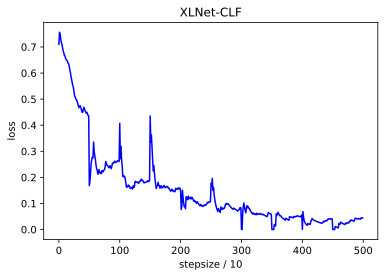

In [0]:
plt.plot(xlnet_loss, 'b')
plt.ylabel('loss')
plt.xlabel('stepsize / 10')
plt.title('XLNet-CLF')
plt.show()

### Test

In [0]:
xlnet_clf.eval()
xlnet_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = xlnet_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        xlnet_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [0]:
## accuracy
xlnet_accuracy = np.mean(test_y == xlnet_predicted)
xlnet_accuracy

0.92

In [0]:
del xlnet_clf
torch.cuda.empty_cache()

## RoBERTa

In [0]:
random.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

### Tokenizing

In [0]:
# refer https://github.com/huggingface/transformers
train_dataloader, test_dataloader = \
    tokenizing_data(tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base'))

100%|██████████| 456318/456318 [00:00<00:00, 1804972.05B/s]


### Declare Model

In [0]:
class robertaBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.2):
        """
        token -> roberta-base -> relu -> FC with dropout -> sigmoid -> label
        """
        super(robertaBinaryClassifier, self).__init__()

        self.roberta = transformers.RobertaModel.from_pretrained('roberta-base')

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, output = self.roberta(tokens, attention_mask=masks)
        output = self.dropout(output)
        output = self.relu(output)
        output = self.linear(output)
        output = self.sigmoid(output)
        return output

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
roberta_clf = robertaBinaryClassifier()

device: cuda


100%|██████████| 501200538/501200538 [00:14<00:00, 34706384.84B/s]


### Optimizer

In [0]:
# Adam
optimizer = Adam(roberta_clf.parameters(), lr = lr)

### Fine-tune

In [0]:
# if 'roberta_clf.pkl' in os.listdir('./models'):
if False:
    # load the model
    roberta_clf = robertaBinaryClassifier()
    roberta_clf.load_state_dict(torch.load('./models/roberta_clf.pkl'))
    roberta_loss = pd.read_csv('./models/roberta_loss.csv', header=None).values.tolist()
    roberta_clf = roberta_clf.to(device)
else:
    # train the model
    roberta_clf = roberta_clf.to(device)
#     roberta_clf = nn.DataParallel(roberta_clf)
    tic = time.time()
    roberta_loss = []
    for epoch_num in range(EPOCHS):
        roberta_clf.train()
        train_loss = 0
        for step_num, batch_data in enumerate(train_dataloader):
            token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
            
            logits = roberta_clf(token_ids, masks)

            loss_func = nn.BCELoss()

            batch_loss = loss_func(logits, labels)
            train_loss += batch_loss.item()

            roberta_clf.zero_grad()
            batch_loss.backward()

            clip_grad_norm_(parameters=roberta_clf.parameters(), max_norm=1.0)
            optimizer.step()

            step_num += 1
            if not (step_num % 10):
                steps = step_num + epoch_num * train_bat
                job_prop = steps / (EPOCHS * train_bat)
                clear_output(wait=True)
                elapsed = time.time() - tic
                print('Epoch: {0}, Elapsed: {1}'.format(epoch_num + 1, elapsed))
                roberta_loss.append(train_loss / (step_num + 1))
                print("\r" + "{0}/{1} loss: {2} ".format(step_num, train_bat, train_loss / (step_num + 1)))
                print("\r" + "{:2.2f}% done".format(100 * job_prop))
            
    # # save the model
    # torch.save(roberta_clf.state_dict(), './models/roberta_clf.pkl')
    
    # # save the loss
    # with open('./models/roberta_loss.csv', 'w') as myfile:
    #     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    #     wr.writerow(roberta_loss)

Epoch: 10, Elapsed: 1361.3194925785065
500/500.0 loss: 0.045900637579025946 
100.00% done


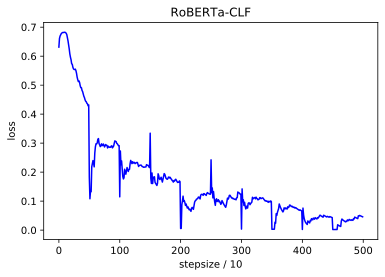

In [0]:
plt.plot(roberta_loss, 'b')
plt.ylabel('loss')
plt.xlabel('stepsize / 10')
plt.title('RoBERTa-CLF')
plt.show()

### Test

In [0]:
roberta_clf.eval()
roberta_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = roberta_clf(token_ids, masks)
        numpy_logits = logits.cpu().detach().numpy()
        
        roberta_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])
        
## accuracy
roberta_accuracy = np.mean(test_y == roberta_predicted)
roberta_accuracy

0.945

In [0]:
del roberta_clf
torch.cuda.empty_cache()

## DistilBERT

In [0]:
random.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

### Tokenizing

In [0]:
# refer https://github.com/huggingface/transformers
train_dataloader, test_dataloader = \
    tokenizing_data(tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased'))

### Declare Model

In [0]:
class distilBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.2):
        """
        token -> distilbert-base -> relu -> FC with dropout -> sigmoid -> label
        """
        super(distilBinaryClassifier, self).__init__()

        self.distil = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        output = self.distil(tokens, attention_mask=masks)
        output = output[0][:,0,:] # The first col. of the last hidden-state (cls)
        output = self.dropout(output)
        output = self.relu(output)
        output = self.linear(output)
        output = self.sigmoid(output)
        return output

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
distil_clf = distilBinaryClassifier()

device: cuda


100%|██████████| 267967963/267967963 [00:07<00:00, 34968032.20B/s]


### Optimizer

In [0]:
# Adam
optimizer = Adam(distil_clf.parameters(), lr = lr)

### Fine-tune

In [0]:
# if 'distil_clf.pkl' in os.listdir('./models'):
if False:
    # load the model
    distil_clf = distilBinaryClassifier()
    distil_clf.load_state_dict(torch.load('./models/distil_clf.pkl'))
    distil_loss = pd.read_csv('./models/distil_loss.csv', header=None).values.tolist()
    distil_clf = distil_clf.to(device)
else:
    # train the model
    distil_clf = distil_clf.to(device)
#     distil_clf = nn.DataParallel(distil_clf)
    tic = time.time()
    distil_loss = []
    for epoch_num in range(EPOCHS):
        distil_clf.train()
        train_loss = 0
        for step_num, batch_data in enumerate(train_dataloader):
            token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
            
            logits = distil_clf(token_ids, masks)

            loss_func = nn.BCELoss()

            batch_loss = loss_func(logits, labels)
            train_loss += batch_loss.item()

            distil_clf.zero_grad()
            batch_loss.backward()

            clip_grad_norm_(parameters=distil_clf.parameters(), max_norm=1.0)
            optimizer.step()
            
            step_num += 1
            if not (step_num % 10):
                steps = step_num + epoch_num * train_bat
                job_prop = steps / (EPOCHS * train_bat)
                clear_output(wait=True)
                elapsed = time.time() - tic
                print('Epoch: {0}, Elapsed: {1}'.format(epoch_num + 1, elapsed))
                distil_loss.append(train_loss / (step_num + 1))
                print("\r" + "{0}/{1} loss: {2} ".format(step_num, train_bat, train_loss / (step_num + 1)))
                print("\r" + "{:2.2f}% done".format(100 * job_prop))
            
    # # save the model
    # torch.save(distil_clf.state_dict(), './models/distil_clf.pkl')
    
    # # save the loss
    # with open('./models/distil_loss.csv', 'w') as myfile:
    #     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    #     wr.writerow(distil_loss)

Epoch: 10, Elapsed: 702.9281578063965
500/500.0 loss: 0.04656520955489499 
100.00% done


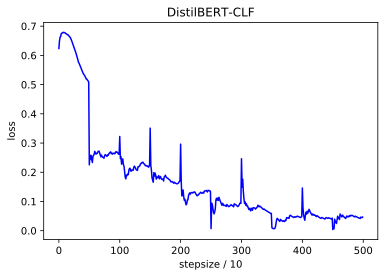

In [0]:
plt.plot(distil_loss, 'b')
plt.ylabel('loss')
plt.xlabel('stepsize / 10')
plt.title('DistilBERT-CLF')
plt.show()

### Test

In [0]:
distil_clf.eval()
distil_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = distil_clf(token_ids, masks)
        numpy_logits = logits.cpu().detach().numpy()
        
        distil_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])
        
## accuracy
distil_accuracy = np.mean(test_y == distil_predicted)
distil_accuracy

0.885

### BV-BERT

Gal, Y. (2016).의 논문을 참고하여 예측을 eval mode (multiplying dropout prob.)가 아닌 train mode에서 실시하였다. 이때, 평균값을 output으로 표준편차를 uncertainty의 측도로 사용하였다. 

In [0]:
distil_clf.train()
n_sample = 20
logits_sample = np.zeros([n_sample, len(test_y)])
with torch.no_grad():
    for i in range(n_sample):
        all_logits = []
        for step_num, batch_data in enumerate(test_dataloader):

            token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

            logits = distil_clf(token_ids, masks)
            numpy_logits = logits.cpu().detach().numpy()
            all_logits += list(numpy_logits[:, 0])
        logits_sample[i,:] = all_logits

In [0]:
test_pred = np.mean(logits_sample, axis = 0)
test_std = np.std(logits_sample, axis = 0)

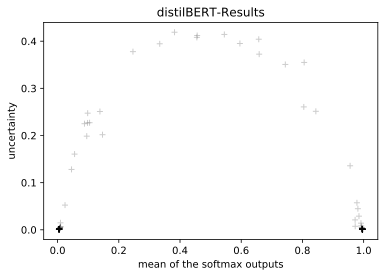

In [0]:
# Gal, Y. (2016). Uncertainty in Deep Learning. PhD Thesis, University of Cambridge, (September). https://doi.org/10.1371/journal.pcbi.1005062
# figure 4.9
plt.plot(test_pred, test_std, 'k+', alpha = 0.2)
plt.xlabel('mean of the softmax outputs')
plt.ylabel('uncertainty')
plt.title('distilBERT-Results')
plt.show()

In [0]:
# sure
print("label: {0}, predicted: {1},\n text: {2}".format(test_labels.tolist()[np.argmin(test_std)], \
                                                       test_pred[np.argmin(test_std)], test_texts[np.argmin(test_std)]))

label: pos, predicted: 0.996284481883049,
 text: Michael Radford, the director of "The Merchant of Venice" makes a tremendous job in opening the play, as he makes it more accessible for everyone to have a great time at the movies watching this thorny account of a horrible time in history. The luscious production of the Shakespeare's play is a feast for the eyes with its rich detail of the Venice of the XVI century.<br /><br />This is a story of revenge, prejudice and justice, as imagined by William Shakespeare. Having seen the play a few times, we were not prepared about what to expect. Mr. Radford takes care of presenting the story with such detail so it can be easily understood by everyone. Also, he has used a version of English that makes more sense, rather than relying on the original text. In fact, the way Shylock speaks in the film, doesn't shock at all, being he, a member of a minority that has been marginalized by the Venetian authorities and the Catholic Church.<br /><br />Al 

In [0]:
# unsure
print("label: {0}, predicted: {1},\n text: {2}".format(test_labels.tolist()[np.argmax(test_std)], \
                                                       test_pred[np.argmax(test_std)], test_texts[np.argmax(test_std)]))

label: pos, predicted: 0.3820604803506285,
 text: 'The Merchant of Venice' is one of Shakespeare's better-known plays and is still regularly performed in the theatre. Incredibly, however, this film would seem to be the first-ever English-language version made for the cinema rather than television. There were a number of versions made in Britain or America during the early days of the cinema, but these were all silents.<br /><br />The reason for this neglect of the play may be connected with sensitivities about the play's alleged anti-Semitism, a subject which has been even more sensitive since the rise to power of the Nazis in 1933. (This may explain why all previous versions were made during the silent era; in 1908 or 1922 it would have been easier to portray Shylock as a straightforward villain than it would be today). Yet in my view the film is not anti-Semitic at all. It should be remembered that during Shakespeare's lifetime there was no settled Jewish community in England; the Je

In [0]:
del distil_clf
torch.cuda.empty_cache()

## Results

In [0]:
print("Results:")
print("BERT: {}".format(bert_accuracy))
print("XLNet: {}".format(xlnet_accuracy))
print("RoBERTa: {}".format(roberta_accuracy))
print("distilBERT_accuracy: {}".format(distil_accuracy))

Results:
BERT: 0.89
XLNet: 0.92
RoBERTa: 0.945
distilBERT_accuracy: 0.885


### Training Time (sec)

* BERT: 1366
* XLNet: 2197
* RoBERTa: 1361
* distilBERT: 703

### Summary

* 최근에 나온 모형일수록 더 나은 성능을 가짐을 확인할 수 있다.  
* distillBERT는 BERT보다 약간 낮은 성능을 갖지만,  학습 시간  등을 고려했을 때 매우 효율적인 모형이라고 생각해볼 수 있다.
* 확정적이지 않은 자료을 분류할 때 불확실성이 커진다는 것을 확인할 수 있다.

## References:

* https://medium.com/swlh/painless-fine-tuning-of-bert-in-pytorch-b91c14912caa
* https://www.analyticsvidhya.com/blog/2019/08/complete-list-important-frameworks-nlp/
* https://towardsdatascience.com/bert-to-the-rescue-17671379687f
* https://github.com/huggingface/transformers
* Gal, Y. (2016). Uncertainty in Deep Learning. PhD Thesis, University of Cambridge, (September). https://doi.org/10.1371/journal.pcbi.1005062
* https://rsilveira79.github.io/fermenting_gradients/machine_learning/nlp/pytorch/text_classification_roberta/